# Haplotypes clustering 

This case study provides an illustrated example for building a pseudo-binary tree with a variable number of nodes per level.
The tree build with this method is intended to be later used as a basis structure for a HMM model which performs phasing and imputation of haplotypes and genotypes.

This original idea has lead to the BEAGLE software. based on the Browning's algorithm which uses Variable-Length Markov Chain (VLMC) for clustering the states at each level of the leveled Hidden Markov Model.
Details of the splitting-merging algorithm: 
* Browning, S.R.: Multilocus association mapping using variable-length markov chains. Am. J. Hum. Genet. 78, 903–913 (2006)
* Browning, S.R., Browning, B.L.: Rapid and accurate haplotype phasing and missing data inference for whole genome association studies by use of localized haplotype clustering. The American Journal of Human Genetics 81, 1084–1097 (2007)


In [2]:
%sx pip3 install networkx

['Requirement already satisfied: networkx in /home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages (2.4)',
 'Requirement already satisfied: decorator>=4.3.0 in /home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages (from networkx) (4.4.1)']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

##  Clustering haplotypes trees

The tree is built upon a set of individual sequences of N genetic diallelic markers, the so called haplotypes.
An arbitrary order is chosen for orienting the binary marker sequences (usually ascending genetic position in the genome).
The root node of the tree contains all haplotypes in the set and then genereates one level of node per marker.
For each level, the haplotypes are first split according to the allele (0 or 1) they carry at this marker,
such that there is possibly in total 2^N + 1 nodes.
The edge connecting two nodes at consecutive levels is weighted by the count of haplotypes carrying the two same alleles,
 and the same previous allelic sequence.
The terminal node of the tree gathers all haplotypes again. 
In a later step, the nodes at a level are merged pairwise if there downstream branches are similar enough in proportions (frequentist criterion).

In [4]:
# Classes and methods featuring a leveled HMM

class Node(object):
    """
    Informations in a node containing haplotypes at one marker.
    To be completed.
    """
    def __init__(self, name, level, parent, allele, haplos):
        self.name = name
        self.level = level
        self.parent = parent
        self.allele = allele
        self.haplos = haplos
    

class Level(object):
    """
    Represent a level in the HMM level.
    One level per marker.
    """
    def __init__(self, graph, templates, levels, L) -> None:
        """
        Initialize data structures and variables
        """
        self.graph = graph  # previous level graph, or root node only
        self.tempset = templates
        self.haplos = []
        self.levs = levels
        self.lv = L   
        self.sublv = 0.0
        
    def build_level(self) -> None:
        """
        Add nodes (binary branching) to each current level node when haplotype counts permit it.
        No edge and node are added if the haplotype counts are zero.
        """
        self.levs[self.lv] = []
        for node in self.levs[self.lv-1]:
            markers = np.array( [self.tempset[k][self.lv-1] for k in node['haplos']] )
            for a in [0, 1]:
                w = np.count_nonzero(markers == a) * 100 
                # up-sample haplotypes 100 x (otherwise Beagle merging method collapses)
                if w != 0:
                    hn = list([k for k in node['haplos'] if self.tempset[k][self.lv-1] == a])
                    newnode = Node(self.lv + self.sublv, self.lv, node['name'], a, hn)
                    self.graph.add_node(self.lv + self.sublv, **newnode.__dict__)
                    self.graph.add_edge(node['name'], self.lv + self.sublv, weight=w, allele=a)
                    self.levs[self.lv].append(dict(self.graph.nodes(data=True)[self.lv + self.sublv]))
                    self.sublv += 0.1        

    def apair_nodes(self) -> list:
        """
        Returns unordered pairs of nodes at a given level.
        """
        nodepairs = []
        for i, nd1 in enumerate(self.levs[self.lv]):
            for nd2 in self.levs[self.lv][i:]:
                if nd1 != nd2:
                    nodepairs.append((nd1['name'], nd2['name']))
        return nodepairs
    
    def merge_nodes(self, nd0, nd1) -> None:
        """
        Decide whether pairs of nodes (nd0, nd1) at same graph level should be merged into a single node.
        Proceed to merging if necessary.
        """
        assert self.graph.nodes(data=True)[nd0]['level'] == self.lv
        assert self.graph.nodes(data=True)[nd1]['level'] == self.lv
        
        par0 = G.nodes(data=True)[nd0]['parent']
        par1 = G.nodes(data=True)[nd1]['parent']
        print('Compare {} and {}'.format(nd0, nd1))
        pare0 = G[par0][nd0][0]
        pare1 = G[par1][nd1][0]
        
        cutscore = ( (1/pare0['weight']) + (1/pare1['weight']) )**0.5
        print('cutting threshold = {}'.format(cutscore))
        
        diffs = []
        for nk0 in G.adj[nd0].keys():
            for nk1 in G.adj[nd1].keys():
                e0 = G[nd0][nk0][0]
                e1 = G[nd1][nk1][0]
                if e0['allele'] == e1['allele']:
                    print('allele: {}'.format(e0))
                    d = np.abs( (e0['weight']/pare0['weight']) - (e1['weight']/pare1['weight']))
                    diffs.append(d)
        
        if diffs != [] and np.max(diffs) < cutscore:
            print(np.max(diffs))
            print('Merging {} and {}\n'.format(nd0, nd1))
            merged_graph = nx.contracted_nodes(self.graph, nd0, nd1)
        
        else:
            print('NOT merging {} and {}\n'.format(nd0, nd1))
            merged_graph = self.graph
            
        return merged_graph

### Haplotypic data
Each template haplotype shows one of the two alleles at each diallelic marker.
Hence, a haplotype is modelized as a binary array.
For human diploid data, every individual would carry two haplotypes along the marker sequences (15 markers in the example set),
such that the 10 templates presented below come from at least 5 individuals.

In [5]:
# Set of template haplotypes to cluster
templates = {
    'H1': np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
    'H2': np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0]),
    'H3': np.array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]),
    'H4': np.array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
    'H5': np.array([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0]),
    'H6': np.array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
    'H7': np.array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]),
    'H8': np.array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0]),
    'H9': np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
    'H10': np.array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0])
}

temparr = np.array(list(templates.values()))

### Initialize the haplotype tree

In [6]:
G=nx.MultiDiGraph()
levels = {}

# create root node
lv = 0  # level
levels[lv] = []

h = list(templates.keys())
rootnode = Node(0, lv, 0, 0.5, h)
G.add_node(0, **rootnode.__dict__)
levels[lv].append(dict(G.nodes(data=True)[0]))

print(dict(G.nodes(data=True)))
print(levels)

{0: {'name': 0, 'level': 0, 'parent': 0, 'allele': 0.5, 'haplos': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10']}}
{0: [{'name': 0, 'level': 0, 'parent': 0, 'allele': 0.5, 'haplos': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10']}]}


In [7]:
# Functions for building the clustered haplotype tree by iterating splitting and merging steps at each level of the graph

def recurse_split(graph, tempset, levs, depth=0, max_depth=0):
    """
    Build the haplotypes binary tree recursively by splitting nodes at each marker
    """
    lv = depth + 1
    print('Splitting at level: ', lv)
    
    L = Level(graph, tempset, levs, lv)
    L.build_level()
                
    if lv + 1 <= max_depth:
        recurse_split(graph, tempset, levs, depth=lv, max_depth=max_depth)
    
    else:
        levels[lv + 1] = []
        lastlevel = [nd['name'] for nd in levs[lv]]
        lastnode = Node(lv + 1, lv, lastlevel, 0.5, tempset)
        graph.add_node(lv + 1, **lastnode.__dict__)
        levels[lv + 1].append(dict(G.nodes(data=True)[lv + 1]))
        for nd in lastlevel:
            graph.add_edge(nd, lv + 1,
                           weight=len(graph.nodes(data=True)[nd]['haplos']) * 100,  # up-sample haplotypes by 100
                           allele=0.5)


def recurse_merge(graph, tempset, levs, depth=0, max_depth=0):
    """
    Build the haplotypes binary tree by merging nodes at each marker
    (merge from the end nodes because of dowstream haplos frequencies)
    """
    depth += 1
    lv = max_depth - depth
    print('Merging at level: ', lv)
    
    L = Level(graph, tempset, levs, lv)
    nodepairs = L.apair_nodes()
    nbpair = len(nodepairs)
    for _ in range(nbpair):
        L = Level(graph, tempset, levs, lv)
        nodepairs = L.apair_nodes()
        for pair in nodepairs:
            try:
                graph = L.merge_nodes(pair[0], pair[1])
            except KeyError:
                break
    
    if depth < max_depth:
        graph = recurse_merge(graph, tempset, levs, depth=depth, max_depth=max_depth)
        
    return graph    
                

## Apply splitting algorithm to the template haplotypes
Recursion depth is limited to 10 markers for better visualization.

In [8]:
# %%prun -D haploclus.cprof 
recurse_split(G, templates, levels, max_depth=10)  # =temparr.shape[-1])
print('Number of nodes in G after splitting -->', len(G.nodes))

Splitting at level:  1
Splitting at level:  2
Splitting at level:  3
Splitting at level:  4
Splitting at level:  5
Splitting at level:  6
Splitting at level:  7
Splitting at level:  8
Splitting at level:  9
Splitting at level:  10
Number of nodes in G after splitting --> 48


{(0, 1.0): 400, (0, 1.1): 600, (1.0, 2.0): 400, (1.1, 2.1): 600, (2.0, 3.0): 200, (2.0, 3.1): 200, (2.1, 3.2): 600, (3.0, 4.0): 200, (3.1, 4.1): 200, (3.2, 4.2): 300, (3.2, 4.3): 300, (4.0, 5.0): 200, (4.1, 5.1): 200, (4.2, 5.2): 200, (4.2, 5.3): 100, (4.3, 5.4): 300, (5.0, 6.0): 200, (5.1, 6.1): 200, (5.2, 6.2): 200, (5.3, 6.3): 100, (5.4, 6.4): 200, (5.4, 6.5): 100, (6.0, 7.0): 200, (6.1, 7.1): 200, (6.2, 7.2): 200, (6.3, 7.3): 100, (6.4, 7.4): 200, (6.5, 7.5): 100, (7.0, 8.0): 200, (7.1, 8.1): 200, (7.2, 8.2): 200, (7.3, 8.3): 100, (7.4, 8.4): 200, (7.5, 8.5): 100, (8.0, 9.0): 200, (8.1, 9.1): 200, (8.2, 9.2): 200, (8.3, 9.3): 100, (8.4, 9.4): 200, (8.5, 9.5): 100, (9.0, 10.0): 200, (9.1, 10.1): 200, (9.2, 10.2): 200, (9.3, 10.3): 100, (9.4, 10.4): 200, (9.5, 10.5): 100, (10.0, 11): 200, (10.1, 11): 200, (10.2, 11): 200, (10.3, 11): 100, (10.4, 11): 200, (10.5, 11): 100}


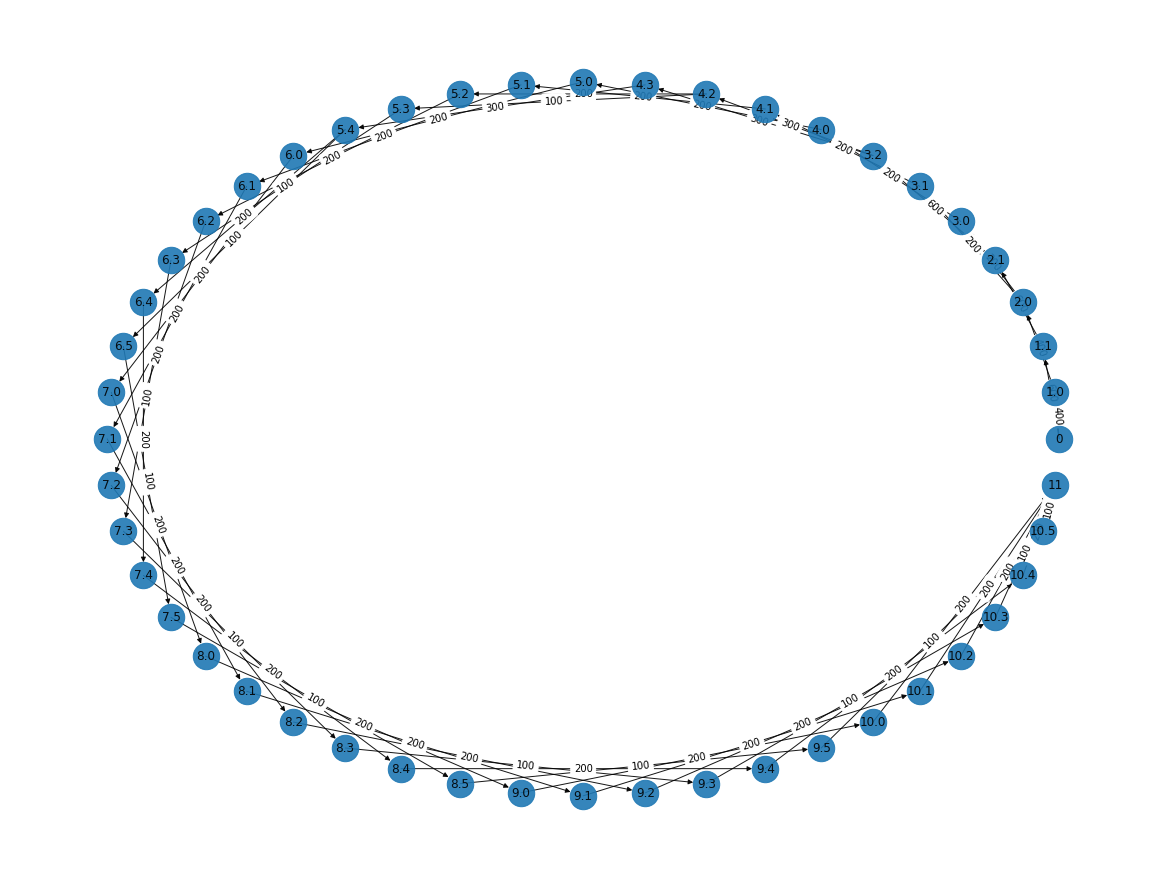

In [9]:
# Draw graph of split haplotypes with circular layout

plt.rcParams["figure.figsize"] = [16, 12]
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, alpha=0.9)
vertices = dict([ ((v[0], v[1]), v[2]['weight']) for v in G.edges(data=True) ])
print(vertices)
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=vertices)
plt.savefig('/home/camille/1000Genomes/plots/haplotree-ex.png')

The circular layout shows an increasing number of edges through the levels (from root node and first marker to last marker screened and last node).
Each edge of the graph shows the number of haplotypes going through this path.
Nodes number have the syntax 'level:sublevel' e.g. the root node has the tag '0' and the nodes containing the haplotypes at the first marker have tags '1.0' and '1.1'. 

/home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


{(0, 1.0): 400, (0, 1.1): 600, (1.0, 2.0): 400, (1.1, 2.1): 600, (2.0, 3.0): 200, (2.0, 3.1): 200, (2.1, 3.2): 600, (3.0, 4.0): 200, (3.1, 4.1): 200, (3.2, 4.2): 300, (3.2, 4.3): 300, (4.0, 5.0): 200, (4.1, 5.1): 200, (4.2, 5.2): 200, (4.2, 5.3): 100, (4.3, 5.4): 300, (5.0, 6.0): 200, (5.1, 6.1): 200, (5.2, 6.2): 200, (5.3, 6.3): 100, (5.4, 6.4): 200, (5.4, 6.5): 100, (6.0, 7.0): 200, (6.1, 7.1): 200, (6.2, 7.2): 200, (6.3, 7.3): 100, (6.4, 7.4): 200, (6.5, 7.5): 100, (7.0, 8.0): 200, (7.1, 8.1): 200, (7.2, 8.2): 200, (7.3, 8.3): 100, (7.4, 8.4): 200, (7.5, 8.5): 100, (8.0, 9.0): 200, (8.1, 9.1): 200, (8.2, 9.2): 200, (8.3, 9.3): 100, (8.4, 9.4): 200, (8.5, 9.5): 100, (9.0, 10.0): 200, (9.1, 10.1): 200, (9.2, 10.2): 200, (9.3, 10.3): 100, (9.4, 10.4): 200, (9.5, 10.5): 100, (10.0, 11): 200, (10.1, 11): 200, (10.2, 11): 200, (10.3, 11): 100, (10.4, 11): 200, (10.5, 11): 100}


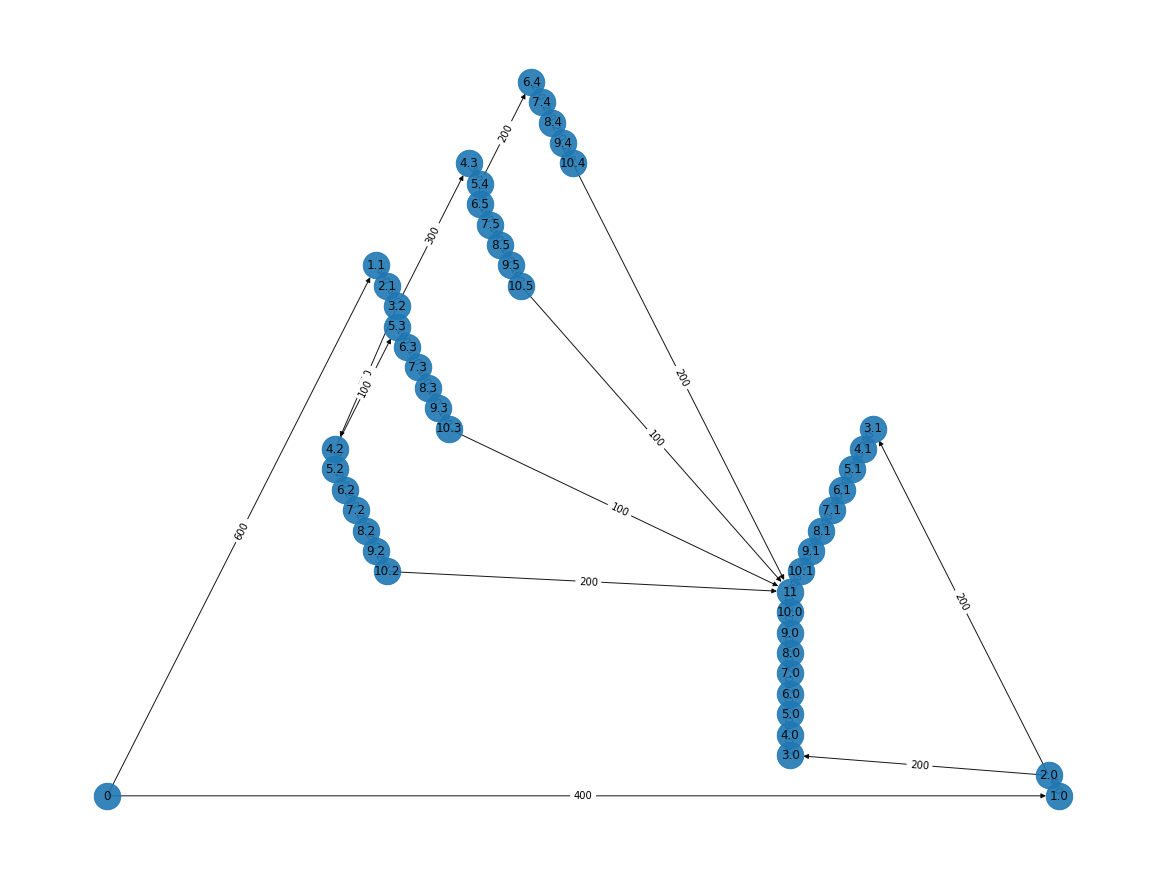

In [10]:
# Draw graph of split haplotypes with planar layout

plt.rcParams["figure.figsize"] = [16, 12]
pos = nx.planar_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, alpha=0.9)
vertices = dict([ ((v[0], v[1]), v[2]['weight']) for v in G.edges(data=True) ])
print(vertices)
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=vertices)
plt.show()

The planar layout allows better visualization of the connections between the edges. 
It is more obvious the tree is pseudo-binary: edges having a 0-count (or weight) are not represented.
This results in 'rowed' nodes: all haplotypes originating from a node have the same allele at the next consecutive marker(s).

In [11]:
# Some examples of NetworkX-graph data 
print('levels in G')
print(levels)
print('\nG.nodes')
print(dict(G.nodes(data=True)))
print(G[0]) # adl node
print('\nG.edges')
print(G.edges(data=True))
print('\ndict from edges')
print(dict([ ((v[0], v[1]), v[2]['weight']) for v in G.edges(data=True) ]))

levels in G
{0: [{'name': 0, 'level': 0, 'parent': 0, 'allele': 0.5, 'haplos': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10']}], 1: [{'name': 1.0, 'level': 1, 'parent': 0, 'allele': 0, 'haplos': ['H1', 'H4', 'H6', 'H9']}, {'name': 1.1, 'level': 1, 'parent': 0, 'allele': 1, 'haplos': ['H2', 'H3', 'H5', 'H7', 'H8', 'H10']}], 2: [{'name': 2.0, 'level': 2, 'parent': 1.0, 'allele': 0, 'haplos': ['H1', 'H4', 'H6', 'H9']}, {'name': 2.1, 'level': 2, 'parent': 1.1, 'allele': 1, 'haplos': ['H2', 'H3', 'H5', 'H7', 'H8', 'H10']}], 3: [{'name': 3.0, 'level': 3, 'parent': 2.0, 'allele': 0, 'haplos': ['H1', 'H9']}, {'name': 3.1, 'level': 3, 'parent': 2.0, 'allele': 1, 'haplos': ['H4', 'H6']}, {'name': 3.2, 'level': 3, 'parent': 2.1, 'allele': 1, 'haplos': ['H2', 'H3', 'H5', 'H7', 'H8', 'H10']}], 4: [{'name': 4.0, 'level': 4, 'parent': 3.0, 'allele': 0, 'haplos': ['H1', 'H9']}, {'name': 4.1, 'level': 4, 'parent': 3.1, 'allele': 0, 'haplos': ['H4', 'H6']}, {'name': 4.2, 'level': 4, 'pare

## Apply merging algorithm to the template haplotypes

In [12]:
M = recurse_merge(G, templates, levels, max_depth=10)
print('Number of nodes in G after merging -->', len(M.nodes))

Merging at level:  9
Compare 9.0 and 9.1
cutting threshold = 0.1
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.0 and 9.1

Compare 9.0 and 9.2
cutting threshold = 0.1
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.0 and 9.2

Compare 9.0 and 9.3
cutting threshold = 0.1224744871391589
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.0 and 9.3

Compare 9.0 and 9.4
cutting threshold = 0.1
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.0 and 9.4

Compare 9.0 and 9.5
cutting threshold = 0.1224744871391589
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.0 and 9.5

Compare 9.1 and 9.2
cutting threshold = 0.1
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.1 and 9.2

Compare 9.1 and 9.3
cutting threshold = 0.1224744871391589
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.1 and 9.3

Compare 9.1 and 9.4
cutting threshold = 0.1
allele: {'weight': 200, 'allele': 1}
0.0
Merging 9.1 and 9.4

Compare 9.1 and 9.5
cutting threshold = 0.1224744871391589
allele: {'weight': 200, 'al

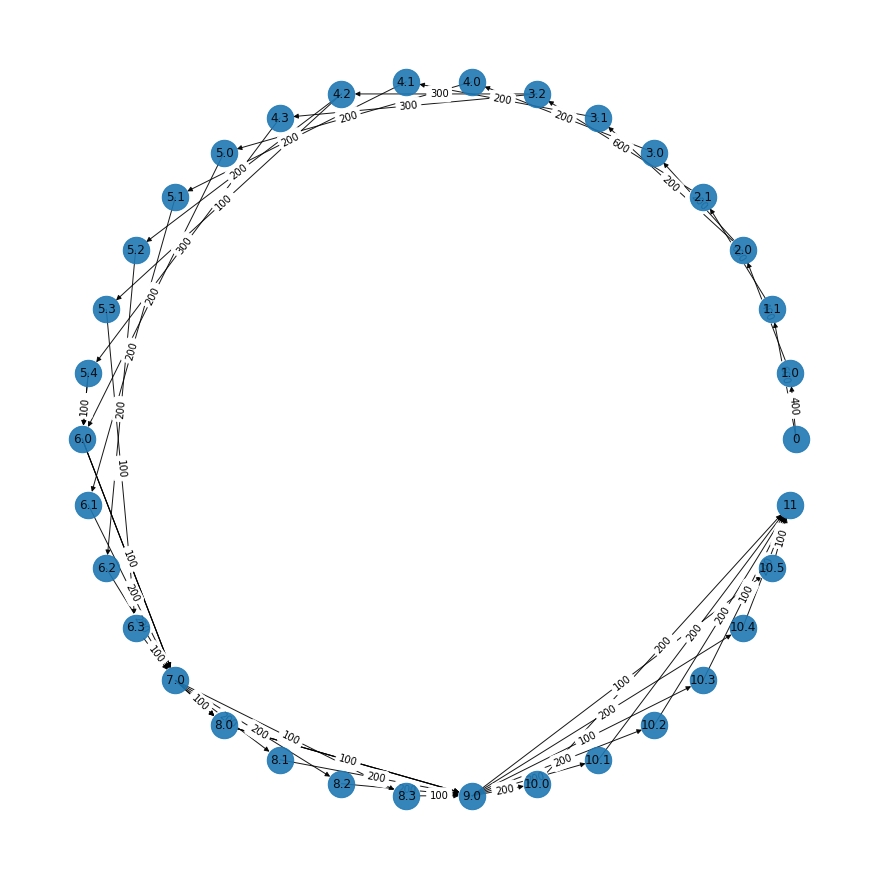

In [13]:
# G has been merged now into M
plt.rcParams["figure.figsize"] = [12, 12]
pos = nx.circular_layout(M)
nx.draw(M, pos, with_labels=True, node_size=700, alpha=0.9)
vertices = dict([ ((v[0], v[1]), v[2]['weight']) for v in M.edges(data=True) ])
nx.draw_networkx_edge_labels(M, pos,
                             edge_labels=vertices)
plt.show()

The circular layout shows well how the amount of edges changes along the levels after merging the nodes int the haplotypes tree.
There are less edges when nodes are merged and the haplotypes collapse into a few or single cluster.
Merging nodes on a frequentist basis captures a higher local Linkage-Disequilibrium between consecutive markers.

The spectral layout used hereafter also shows themerging events well.

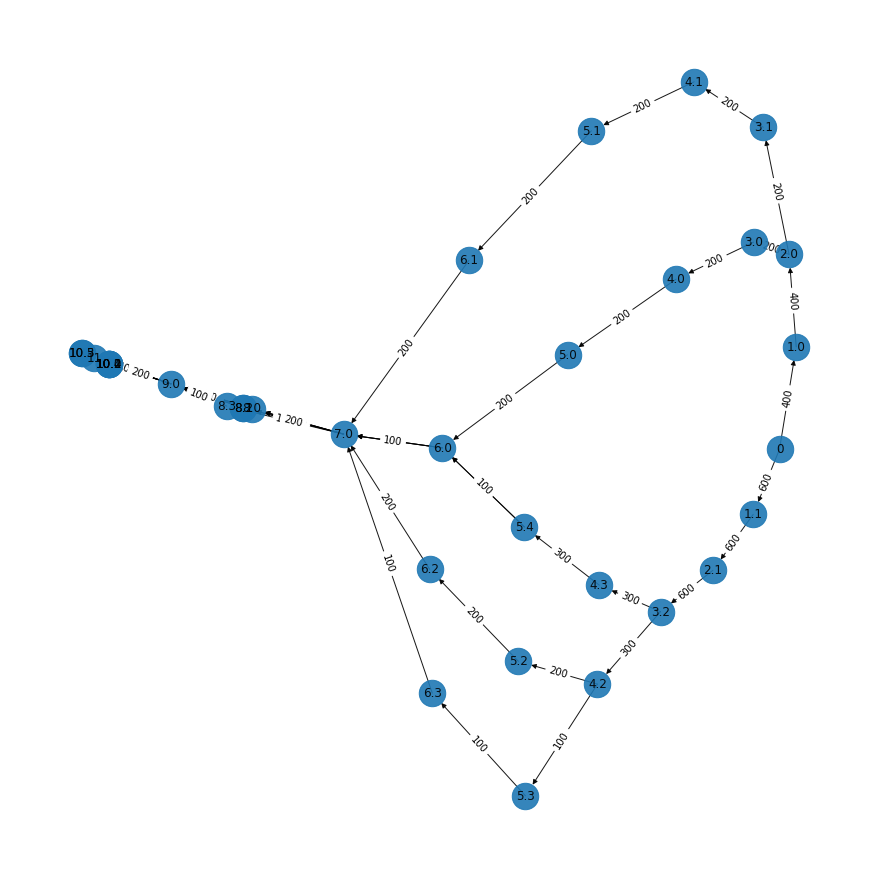

In [14]:
plt.rcParams["figure.figsize"] = [12, 12]
pos = nx.spectral_layout(M)
nx.draw(M, pos, with_labels=True, node_size=700, alpha=0.9)
vertices = dict([ ((v[0], v[1]), v[2]['weight']) for v in M.edges(data=True) ])
nx.draw_networkx_edge_labels(M, pos,
                             edge_labels=vertices)
plt.show()

